# KE5006 Applied Research

### Identifying enhancers and their strength with deep neural networks

# Preliminary Layer 1 Model with Physiochemical Property Features

## Summary of Findings
* Base model of 2x16 GRU
	* Overfits with a maximum validation accuracy of 75.51% at epoch 232 on 2:1 split.
* Base model of 1x8 GRU
	* Overfits with a maximum validation accuracy of 75.61% at epoch 586 on 2:1 split.
* Base model of 4x8 GRU, 2x8 Dense
	* Overfits with a maximum validation accuracy of 75.41% at epoch 322 on 2:1 split.

## Load libraries

In [1]:
# Set the working directory (which contains the directories source, data, etc.)
import os
os.chdir(os.path.join(os.path.sep, 'home', 'tkokkeng', 'Documents', 'KE5006-AppliedResearch', 'enhancer'))
os.getcwd()

'/home/tkokkeng/Documents/KE5006-AppliedResearch/enhancer'

In [2]:
# Check if the directory containing the source files are in the path.
import sys
if os.path.join(os.getcwd(), 'source') not in sys.path:
    sys.path.append(os.path.join(os.getcwd(), 'source'))
sys.path

['/home/tkokkeng/python/python367/tsfvenv/lib/python36.zip',
 '/home/tkokkeng/python/python367/tsfvenv/lib/python3.6',
 '/home/tkokkeng/python/python367/tsfvenv/lib/python3.6/lib-dynload',
 '/usr/lib/python3.6',
 '',
 '/home/tkokkeng/python/python367/tsfvenv/lib/python3.6/site-packages',
 '/home/tkokkeng/.local/lib/python3.6/site-packages',
 '/usr/local/lib/python3.6/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/home/tkokkeng/python/python367/tsfvenv/lib/python3.6/site-packages/IPython/extensions',
 '/home/tkokkeng/.ipython',
 '/home/tkokkeng/Documents/KE5006-AppliedResearch/enhancer/source']

In [3]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime

import myUtilities as mu

from sklearn.metrics import classification_report, confusion_matrix, matthews_corrcoef, make_scorer, recall_score, roc_auc_score, roc_curve 
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.preprocessing import MinMaxScaler

from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

Using TensorFlow backend.


## Load data

In [4]:
enhancer_df = pd.read_csv(os.path.join('data', 'enhancer.csv'))
enhancer_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1484 entries, 0 to 1483
Data columns (total 2 columns):
id          1484 non-null object
sequence    1484 non-null object
dtypes: object(2)
memory usage: 23.3+ KB


In [5]:
enhancer_df['enhancer'] = np.ones((len(enhancer_df),))

In [6]:
enhancer_df.head()

,id,sequence,enhancer
0,CHRX_48897056_48897256,CACAATGTAGAAGCAGAGACACAGGAACCAGGCTTGGTGATGGCTC...,1.0
1,CHR12_6444339_6444539,GCCCTCACATTCCCTGGCCCATCCCCTCCACCTCAAAATTTACAAA...,1.0
2,CHR12_6444939_6445139,GAGCAGGAGGCCAGTCACCCTGAGTCAGCCACGGGGAGACGCTGCA...,1.0
3,CHR12_6445139_6445339,CCTCTGCTGAGAACAGGACTGGGGCTTCCAGGGCAACAGGAAGGGT...,1.0
4,CHR12_6445339_6445539,ACAGCCTTAAAGGGAGCTTTTCAGGGACCTCTGGCCAGTGGGGGAT...,1.0


In [7]:
non_enhancer_df = pd.read_csv(os.path.join('data', 'non_enhancer.csv'))
non_enhancer_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1484 entries, 0 to 1483
Data columns (total 2 columns):
id          1484 non-null object
sequence    1484 non-null object
dtypes: object(2)
memory usage: 23.3+ KB


In [8]:
non_enhancer_df['enhancer'] = np.zeros((len(non_enhancer_df),))

In [9]:
non_enhancer_df.head()

,id,sequence,enhancer
0,CHRX_2970600_2970800,CAGTCACATCTGTAATCACAATACGTTGGGAGGCTGAGGCAGGAGG...,0.0
1,CHRX_6179400_6179600,ACTTTGAAGAAGTCAGTCATCAAGATGAGAGACCCAACTGTCAAGC...,0.0
2,CHRX_11003079_11003279,TCGGCCTCCCAAAGTGCTGGGATTATAGGCATGAGCTACTGCACCC...,0.0
3,CHRX_22042679_22042879,TGGGAGCTGTATCAATCATGTTTTTTATTTTCTATATTTTATGATG...,0.0
4,CHRX_23280479_23280679,TACAGCAAATAGCCTTGGCAGATACAGTGTTTCCCTCCAGAGCAAA...,0.0


## Combine the data frames to form a single dataset

In [10]:
all_data_df = pd.concat([enhancer_df, non_enhancer_df])
all_data_df.reset_index(drop=True, inplace=True)
all_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2968 entries, 0 to 2967
Data columns (total 3 columns):
id          2968 non-null object
sequence    2968 non-null object
enhancer    2968 non-null float64
dtypes: float64(1), object(2)
memory usage: 69.6+ KB


In [11]:
all_data_df.head()

,id,sequence,enhancer
0,CHRX_48897056_48897256,CACAATGTAGAAGCAGAGACACAGGAACCAGGCTTGGTGATGGCTC...,1.0
1,CHR12_6444339_6444539,GCCCTCACATTCCCTGGCCCATCCCCTCCACCTCAAAATTTACAAA...,1.0
2,CHR12_6444939_6445139,GAGCAGGAGGCCAGTCACCCTGAGTCAGCCACGGGGAGACGCTGCA...,1.0
3,CHR12_6445139_6445339,CCTCTGCTGAGAACAGGACTGGGGCTTCCAGGGCAACAGGAAGGGT...,1.0
4,CHR12_6445339_6445539,ACAGCCTTAAAGGGAGCTTTTCAGGGACCTCTGGCCAGTGGGGGAT...,1.0


All the sequences are of length 200 characters.

In [12]:
all_data_df['sequence'].map(lambda x: len(x)).value_counts()

200    2968
Name: sequence, dtype: int64

## Load the physiochemical property data

In [13]:
pcp_df = pd.read_csv(os.path.join('data', 'S2.csv'), index_col=0)
pcp_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16 entries, AA to TT
Data columns (total 6 columns):
Rise     16 non-null float64
Roll     16 non-null float64
Shift    16 non-null float64
Slide    16 non-null float64
Tilt     16 non-null float64
Twist    16 non-null float64
dtypes: float64(6)
memory usage: 896.0+ bytes


In [14]:
scaler = MinMaxScaler()
pcp_df.loc[:, :] = scaler.fit_transform(pcp_df.values)
pcp_df

,Rise,Roll,Shift,Slide,Tilt,Twist
AA,0.430303,0.403042,1.000000,0.545455,0.4,0.833333
AC,0.818182,0.695817,0.618557,1.000000,0.7,0.833333
AG,0.257576,0.315589,0.762887,0.772727,0.3,0.791667
AT,0.860606,1.000000,0.319588,0.863636,0.6,0.750000
CA,0.045455,0.220532,0.360825,0.090909,0.1,0.291667
CC,0.548485,0.171103,0.731959,0.545455,0.3,1.000000
CG,0.000000,0.304183,0.371134,0.000000,0.0,0.333333
CT,0.257576,0.315589,0.762887,0.772727,0.3,0.791667
GA,0.706061,0.277567,0.618557,0.500000,0.4,0.833333
GC,1.000000,0.536122,0.494845,0.500000,1.0,0.750000


## Prepare the sequence data for modelling

Create a transformation pipleline to prepare the training dataset for RNN.

In [15]:
# This class selects the desired attributes and drops the rest.
class DataFrameSelector(BaseEstimator, TransformerMixin):

    def __init__(self, attribute_names):
        self.attribute_names = attribute_names

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.attribute_names]

In [16]:
# This class converts a nucleotide base (A, C, G, T) to one-hot-encoding.
class one_hot_encoder(BaseEstimator, TransformerMixin):

    def __init__(self):
        self.tokenizer = Tokenizer(num_words=4, lower=False, char_level=True)

    def fit(self, X, y=None):
        # Note that X is a data frame.
        # Fit the tokenizer on the 1st sequence in the dataset.
        self.tokenizer.fit_on_texts(X.iloc[0, 0])
        self.len_sequence = len(X.iloc[0, 0])
        return self

    def transform(self, X):
        # Note that X is a data frame.
        one_hot_X = X.iloc[:, 0].map(lambda x: self.tokenizer.texts_to_matrix(x, mode='binary')).values
        one_hot_X = np.concatenate(one_hot_X)
        one_hot_X = np.reshape(one_hot_X, (-1, self.len_sequence, 4))
        return one_hot_X

In [17]:
# This class converts a sequence of nucleotide bases (A, C, G, T) to a sequence of dinucleotides and then to a sequence of pysiochemical properties of each dinucleotide.
class pcp_encoder(BaseEstimator, TransformerMixin):

    def __init__(self, pcp_df):
        self.pcp_df = pcp_df

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # Note that X is a data frame.
        dinuc_seq = X.iloc[:, 0].map(lambda x: [ x[i:i+2] for i in range(len(x) - 1) ])
        pcp_seq = dinuc_seq.map(lambda x: [ pcp_df[j][i] for i in x for j in pcp_df.columns.tolist() ])
        # Pad with -1 for last element of sequence; it does not have an associated di-nucleotide
        pcp_seq = pcp_seq.map(lambda x: np.array(x + [-1. for i in range(len(pcp_df.columns))]).reshape((len(X.iloc[0, 0]), len(pcp_df.columns)))).values
        # pandas values returns a 1-D array of objects; use numpy stack to reshape it to a multi-dimensional array
        return np.stack(pcp_seq)

In [18]:
# This class shapes a numpy array.
class Array_Shaper(BaseEstimator, TransformerMixin):
    
    def __init__(self, shape):
        self.shape = shape
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.reshape(self.shape)

In [19]:
attrbs = ['sequence']
num_bases = 4  # number of nucleotide bases
num_pcp = 6  # number of di-nucleotide physiochemical properties
len_seq = len(all_data_df['sequence'][0])
one_hot_pipeline = Pipeline([
    ('selector', DataFrameSelector(attrbs)),
    ('one_hot_encoder', one_hot_encoder()),
    ('array_shaper2D', Array_Shaper((-1, num_bases)))
])
pcp_pipeline = Pipeline([
    ('selector', DataFrameSelector(attrbs)),
    ('pcp_encoder', pcp_encoder(pcp_df)),
    ('array_shaper2D', Array_Shaper((-1, num_pcp)))
])
union_pipeline = FeatureUnion(transformer_list=[
    ("one_hot_pipeline", one_hot_pipeline),
    ("pcp_pipeline", pcp_pipeline)
])
my_pipeline = Pipeline([
    ('feature_combiner', union_pipeline),
    ('array_shaper3D', Array_Shaper((-1, len_seq, num_bases + num_pcp)))
])

In [20]:
X = my_pipeline.fit_transform(all_data_df)
X.shape

(2968, 200, 10)

Check the 1st sequence is correctly encoded.

In [21]:
X[0, :10, :]

array([[0.        , 0.        , 0.        , 0.        , 0.04545455,
        0.22053232, 0.36082474, 0.09090909, 0.1       , 0.29166667],
       [0.        , 0.        , 0.        , 1.        , 0.81818182,
        0.69581749, 0.6185567 , 1.        , 0.7       , 0.83333333],
       [0.        , 0.        , 0.        , 0.        , 0.04545455,
        0.22053232, 0.36082474, 0.09090909, 0.1       , 0.29166667],
       [0.        , 0.        , 0.        , 1.        , 0.43030303,
        0.40304183, 1.        , 0.54545455, 0.4       , 0.83333333],
       [0.        , 0.        , 0.        , 1.        , 0.86060606,
        1.        , 0.31958763, 0.86363636, 0.6       , 0.75      ],
       [0.        , 0.        , 1.        , 0.        , 0.04545455,
        0.22053232, 0.36082474, 0.09090909, 0.1       , 0.29166667],
       [0.        , 1.        , 0.        , 0.        , 0.81818182,
        0.69581749, 0.6185567 , 1.        , 0.7       , 0.83333333],
       [0.        , 0.        , 1.       

In [22]:
X[0, -10:, :]

array([[ 0.        ,  0.        ,  1.        ,  0.        ,  0.43030303,
         0.40304183,  1.        ,  0.54545455,  0.4       ,  0.83333333],
       [ 0.        ,  0.        ,  1.        ,  0.        ,  0.04545455,
         0.22053232,  0.36082474,  0.09090909,  0.1       ,  0.29166667],
       [ 0.        ,  1.        ,  0.        ,  0.        ,  0.81818182,
         0.69581749,  0.6185567 ,  1.        ,  0.7       ,  0.83333333],
       [ 0.        ,  0.        ,  1.        ,  0.        ,  0.70606061,
         0.27756654,  0.6185567 ,  0.5       ,  0.4       ,  0.83333333],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.54848485,
         0.17110266,  0.73195876,  0.54545455,  0.3       ,  1.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.25757576,
         0.31558935,  0.7628866 ,  0.77272727,  0.3       ,  0.79166667],
       [ 0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.13636364

In [23]:
y = all_data_df['enhancer'].values
y.shape

(2968,)

In [24]:
y[:10]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

## Split the dataset into train / validation sets

For the initial base model, we will use a simple train / validation split. 5-fold cross-validation will be used during model fine-tuning to obtain the final model.

In [25]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, random_state=123)

In [26]:
X_train.shape

(1988, 200, 10)

In [27]:
X_train[0][:10]

array([[0.        , 0.        , 0.        , 0.        , 0.25757576,
        0.31558935, 0.7628866 , 0.77272727, 0.3       , 0.79166667],
       [0.        , 0.        , 1.        , 0.        , 0.        ,
        0.        , 0.        , 0.13636364, 0.        , 0.        ],
       [0.        , 0.        , 0.        , 1.        , 0.81818182,
        0.69581749, 0.6185567 , 1.        , 0.7       , 0.83333333],
       [0.        , 0.        , 0.        , 0.        , 0.54848485,
        0.17110266, 0.73195876, 0.54545455, 0.3       , 1.        ],
       [0.        , 0.        , 0.        , 0.        , 0.04545455,
        0.22053232, 0.36082474, 0.09090909, 0.1       , 0.29166667],
       [0.        , 0.        , 0.        , 1.        , 0.43030303,
        0.40304183, 1.        , 0.54545455, 0.4       , 0.83333333],
       [0.        , 0.        , 0.        , 1.        , 0.86060606,
        1.        , 0.31958763, 0.86363636, 0.6       , 0.75      ],
       [0.        , 0.        , 1.       

In [28]:
y_train.shape

(1988,)

In [29]:
y_train[0]

1.0

## Train a base RNN model

In this training phase, the aim is to find a base model with statistical power which overfits. Interatively, this base model will be scaled up first to overfit, to be followed by regularization, to improve the validation accuracy.

In the next phase, cross-validation will be applied to obtain better estimates of validation accuracy. Grid-search can be applied to fine-tune the parameters, hyper-parameters to further improve the validation accuracy.

### 2 Layer 16 Node GRU

In [30]:
from numpy.random import seed
seed(123)
from tensorflow import set_random_seed
set_random_seed(456)

In [31]:
model = Sequential()
model.add(layers.CuDNNGRU(16, return_sequences=True, input_shape=(None, X_train.shape[-1])))
model.add(layers.CuDNNGRU(16))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer=RMSprop(), loss='binary_crossentropy', metrics=['acc'])

In [32]:
t1 = datetime.datetime.now()
print('Training start time = %s' %  t1)
history = model.fit(X_train, y_train,
                    batch_size=128,  epochs=1000, verbose=0,
                    validation_data=(X_val, y_val), shuffle=True)
print('\nTraining Duration = %s' % (datetime.datetime.now()-t1))

Training start time = 2019-03-03 16:38:46.693098

Training Duration = 0:04:10.557741


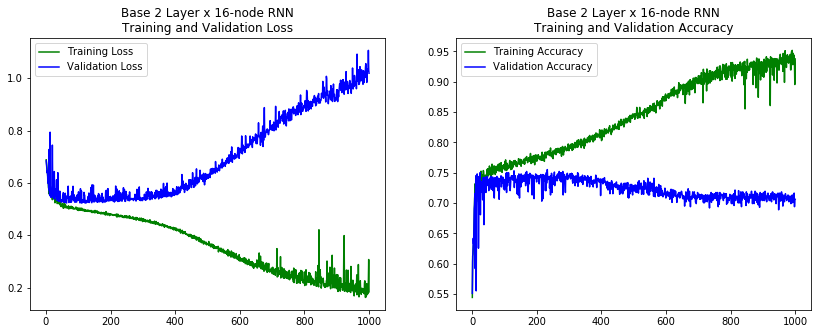

In [33]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['acc']
val_acc = history.history['val_acc']
epochs = range(1, len(train_loss) + 1)
plt.figure(figsize=(14, 5))
plt.subplot(121)
plt.plot(epochs, train_loss, 'g', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Base 2 Layer x 16-node RNN\nTraining and Validation Loss')
plt.legend()
plt.subplot(122)
plt.plot(epochs, train_acc, 'g', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Base 2 Layer x 16-node RNN\nTraining and Validation Accuracy')
plt.legend()
plt.show()

The model overfits early. Maximum validation accuracy on this simple base model is **75**%, achieved after 317 epochs. We need to regularize the model to get a better accuracy.

In [34]:
print('validation loss = {:6.2f} at epoch = {:4d}'.format(min(val_loss), val_loss.index(min(val_loss))))
print('validation accuracy = {:6.2f}% at epoch = {:4d}'.format(max(val_acc) * 100, val_acc.index(max(val_acc))))

validation loss =   0.52 at epoch =  120
validation accuracy =  75.51% at epoch =  232


### Single Layer 8 Node GRU

In [35]:
from numpy.random import seed
seed(123)
from tensorflow import set_random_seed
set_random_seed(456)

In [36]:
model = Sequential()
model.add(layers.CuDNNGRU(8, input_shape=(None, X_train.shape[-1])))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer=RMSprop(), loss='binary_crossentropy', metrics=['acc'])

In [37]:
t1 = datetime.datetime.now()
print('Training start time = %s' %  t1)
history = model.fit(X_train, y_train,
                    batch_size=128,  epochs=1000, verbose=0,
                    validation_data=(X_val, y_val), shuffle=True)
print('\nTraining Duration = %s' % (datetime.datetime.now()-t1))

Training start time = 2019-03-03 16:44:28.633620

Training Duration = 0:02:33.661784


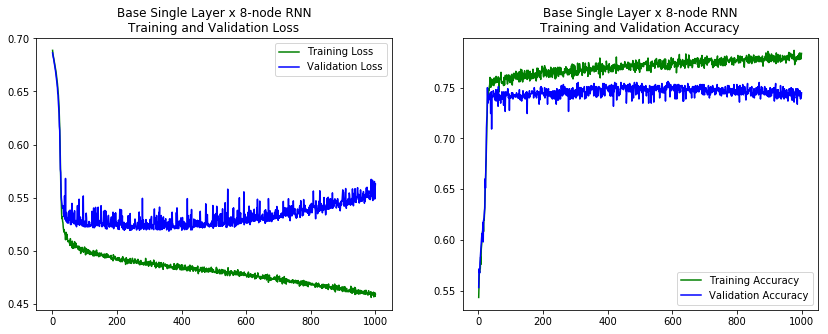

In [38]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['acc']
val_acc = history.history['val_acc']
epochs = range(1, len(train_loss) + 1)
plt.figure(figsize=(14, 5))
plt.subplot(121)
plt.plot(epochs, train_loss, 'g', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Base Single Layer x 8-node RNN\nTraining and Validation Loss')
plt.legend()
plt.subplot(122)
plt.plot(epochs, train_acc, 'g', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Base Single Layer x 8-node RNN\nTraining and Validation Accuracy')
plt.legend()
plt.show()

In [39]:
print('validation loss = {:6.2f} at epoch = {:4d}'.format(min(val_loss), val_loss.index(min(val_loss))))
print('validation accuracy = {:6.2f}% at epoch = {:4d}'.format(max(val_acc) * 100, val_acc.index(max(val_acc))))

validation loss =   0.52 at epoch =  360
validation accuracy =  75.61% at epoch =  586


### 4x8 GRU, 2x8 Dense Model

In [40]:
from numpy.random import seed
seed(123)
from tensorflow import set_random_seed
set_random_seed(456)

In [41]:
model = Sequential()
model.add(layers.CuDNNGRU(8, return_sequences=True, input_shape=(None, X_train.shape[-1])))
model.add(layers.CuDNNGRU(8, return_sequences=True))
model.add(layers.CuDNNGRU(8, return_sequences=True))
model.add(layers.CuDNNGRU(8))
model.add(layers.Dense(8, activation='relu')) 
model.add(layers.Dense(8, activation='relu')) 
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer=RMSprop(), loss='binary_crossentropy', metrics=['acc'])

In [42]:
callbacks_list = [
    # ModelCheckpoint(
    #     filepath='base1mrb-4x128gru-2x32dense.best.h5',
    #     monitor='val_loss',
    #     save_best_only=True
    # ),
    TensorBoard(
        log_dir='tsb_log'
    )
]

In [43]:
t1 = datetime.datetime.now()
print('Training start time = %s' %  t1)
history = model.fit(X_train, y_train,
                    batch_size=128,  epochs=1000, verbose=0,
                    callbacks=callbacks_list,
                    validation_data=(X_val, y_val), shuffle=True)
print('\nTraining Duration = %s' % (datetime.datetime.now()-t1))

Training start time = 2019-03-03 16:47:55.382044

Training Duration = 0:07:28.829745


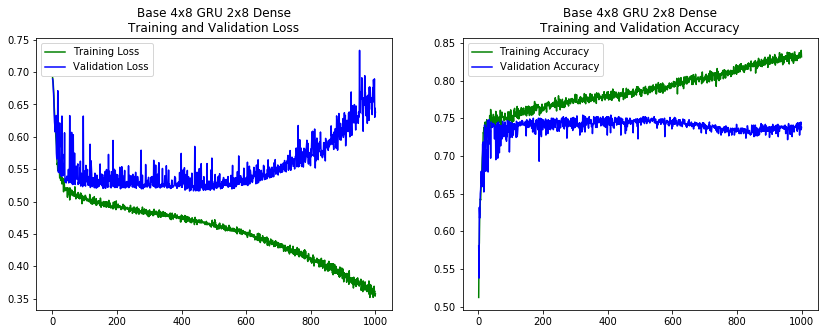

In [44]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['acc']
val_acc = history.history['val_acc']
epochs = range(1, len(train_loss) + 1)
plt.figure(figsize=(14, 5))
plt.subplot(121)
plt.plot(epochs, train_loss, 'g', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Base 4x8 GRU 2x8 Dense\nTraining and Validation Loss')
plt.legend()
plt.subplot(122)
plt.plot(epochs, train_acc, 'g', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Base 4x8 GRU 2x8 Dense\nTraining and Validation Accuracy')
plt.legend()
plt.show()

In [45]:
print('validation loss = {:6.2f} at epoch = {:4d}'.format(min(val_loss), val_loss.index(min(val_loss))))
print('validation accuracy = {:6.2f}% at epoch = {:4d}'.format(max(val_acc) * 100, val_acc.index(max(val_acc))))

validation loss =   0.52 at epoch =  424
validation accuracy =  75.41% at epoch =  322


## Ignore all below ...

### Train the model with early stopping

In [32]:
from numpy.random import seed
seed(123)
from tensorflow import set_random_seed
set_random_seed(456)

In [55]:
model = Sequential()
model.add(layers.CuDNNGRU(16, input_shape=(None, X_train.shape[-1])))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer=RMSprop(), loss='binary_crossentropy', metrics=['acc'])

In [56]:
callbacks_list = [
    EarlyStopping(monitor='val_acc', patience=20, restore_best_weights=True)
]

In [57]:
t1 = datetime.datetime.now()
print('Training start time = %s' %  t1)
history = model.fit(X_train, y_train,
                    batch_size=128,  epochs=1000, verbose=0,
                    callbacks=callbacks_list, validation_data=(X_val, y_val), shuffle=True)
print('\nTraining Duration = %s' % (datetime.datetime.now()-t1))

Training start time = 2019-01-27 23:07:32.714040

Training Duration = 0:00:15.731143


In [73]:
print('Early stopping occurred after epoch \033[1m{:d}\033[0m'.format(callbacks_list[0].stopped_epoch))

Early stopping occurred after epoch 107


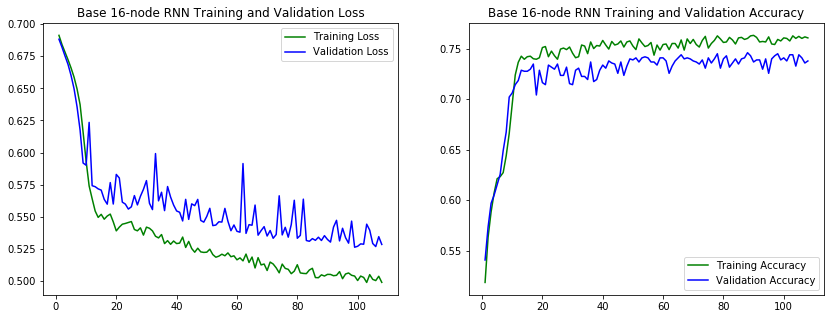

In [74]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['acc']
val_acc = history.history['val_acc']
epochs = range(1, len(train_loss) + 1)
plt.figure(figsize=(14, 5))
plt.subplot(121)
plt.plot(epochs, train_loss, 'g', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Base 16-node RNN Training and Validation Loss')
plt.legend()
plt.subplot(122)
plt.plot(epochs, train_acc, 'g', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Base 16-node RNN Training and Validation Accuracy')
plt.legend()
plt.show()

In [60]:
y_train_pred = model.predict_classes(X_train)
y_val_pred = model.predict_classes(X_val)

In [61]:
print('train preds = %s\nvalidation preds = %s' % (y_train_pred.shape, y_val_pred.shape))

train preds = (1988, 1)
validation preds = (980, 1)


In [62]:
y_train_pred[:10]

array([[1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0]], dtype=int32)

In [63]:
cf_matrix_train = confusion_matrix(y_train, y_train_pred)
cf_matrix_train

array([[798, 207],
       [261, 722]])

In [64]:
cf_matrix_val = confusion_matrix(y_val, y_val_pred)
cf_matrix_val

array([[372, 107],
       [142, 359]])

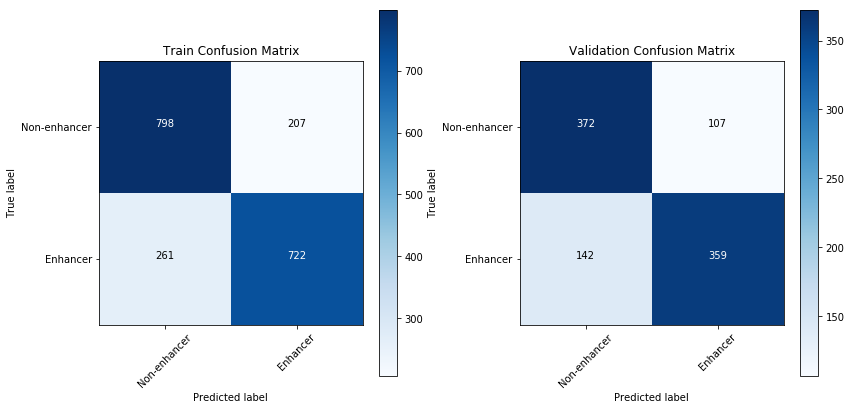

In [65]:
plt.figure(figsize=(12, 6))
plt.subplot(121)
mu.plot_confusion_matrix(cf_matrix_train, classes= ['Non-enhancer', 'Enhancer'], title='Train Confusion Matrix')
plt.subplot(122)
mu.plot_confusion_matrix(cf_matrix_val, classes= ['Non-enhancer', 'Enhancer'], title='Validation Confusion Matrix')
plt.show()

In [67]:
print(classification_report(y_train, y_train_pred, target_names=['Non-enhancer', 'Enhancer']))

              precision    recall  f1-score   support

Non-enhancer       0.75      0.79      0.77      1005
    Enhancer       0.78      0.73      0.76       983

   micro avg       0.76      0.76      0.76      1988
   macro avg       0.77      0.76      0.76      1988
weighted avg       0.77      0.76      0.76      1988



### Try out 5-fold Stratified Cross-validation

In [41]:
# Function to create model, required for KerasClassifier
def create_model():
    
    # create model
    model = Sequential()
    model.add(layers.CuDNNGRU(16, input_shape=(None, X_train.shape[-1])))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer=RMSprop(), loss='binary_crossentropy', metrics=['acc'])
   
    return model

In [42]:
from numpy.random import seed
seed(123)
from tensorflow import set_random_seed
set_random_seed(456)

In [43]:
# note that the monitored metric is acc (not val_acc) because there is no 'validation set'; the validation fold in X-validation is for scoring after training.
callbacks_list = [
    EarlyStopping(monitor='acc', patience=20, restore_best_weights=True)
]

In [44]:
# Create model; we set max 800 epochs based on the early training session. 
model = KerasClassifier(build_fn=create_model, epochs=800, batch_size=128, verbose=0)

In [45]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)  # random_state only used when shuffle == True

In [46]:
# customer scorer function for specificity
def specificity(y, y_pred):
    # print(y_pred)
    tn, fp = 0, 0
    for idx, a_pred in enumerate(y_pred):
        if a_pred and not(y[idx]):
            fp += 1
        elif not(a_pred) and not(y[idx]):
            tn += 1
    return tn/(tn+fp)

In [47]:
scoring = {'accuracy':'accuracy',
           'sensitivity':'recall',
           'specificity':make_scorer(specificity),
           'mcc':make_scorer(matthews_corrcoef),
           'auc':'roc_auc'}

In [48]:
t1 = datetime.datetime.now()
print('Training start time = {}'.format(t1))
scores = cross_validate(model, X=X, y=y, scoring=scoring, cv=skf, n_jobs=None, verbose=0, return_train_score=True, fit_params={'callbacks':callbacks_list})  #, return_estimator=True)
t2 = datetime.datetime.now()
print('Training duration = {}'.format(t2 - t1))

Training start time = 2019-01-28 00:03:56.063151
Training duration = 0:00:56.725499


In [49]:
scores

{'fit_time': array([11.10198593, 14.62846208,  9.06343579,  9.54099512, 10.28102303]),
 'score_time': array([0.11169457, 0.1225841 , 0.13033438, 0.14405155, 0.15876365]),
 'test_accuracy': array([0.72895623, 0.73063973, 0.78619529, 0.75589226, 0.74493243]),
 'train_accuracy': array([0.7556866 , 0.74304971, 0.73967987, 0.75442291, 0.73021886]),
 'test_sensitivity': array([0.71380471, 0.81144781, 0.73063973, 0.73063973, 0.84121622]),
 'train_sensitivity': array([0.75737152, 0.83909014, 0.65627633, 0.72283067, 0.82575758]),
 'test_specificity': array([0.74410774, 0.64983165, 0.84175084, 0.78114478, 0.64864865]),
 'train_specificity': array([0.75400168, 0.64700927, 0.8230834 , 0.78601516, 0.63468013]),
 'test_mcc': array([0.45812285, 0.46742436, 0.5759569 , 0.51243848, 0.49920819]),
 'train_mcc': array([0.51137611, 0.49532277, 0.48617121, 0.50986461, 0.46908054]),
 'test_auc': array([0.80234443, 0.82244442, 0.85563831, 0.80995137, 0.82219001]),
 'train_auc': array([0.82826521, 0.83080323, 

In [50]:
# 95% of the area of a normal distribution is within 1.96 standard deviations of the mean
print("Validation Accuracy = {:0.2f} (+/- {:0.2f})%".format(scores['test_accuracy'].mean() * 100.0, scores['test_accuracy'].std() * 196.0))

Validation Accuracy = 74.93 (+/- 4.10)%


In [53]:
results_dict = {}
for i in ['test_accuracy', 'test_sensitivity', 'test_specificity', 'test_mcc', 'test_auc']:
    results_dict[i] = [round(scores[i].mean(), 4), round(scores[i].std() * 1.96, 4)]
results_df = pd.DataFrame.from_dict(results_dict, orient='index')
results_df.columns = ['mean', 'std']
results_df

,mean,std
test_accuracy,0.7493,0.0410
test_sensitivity,0.7655,0.0997
test_specificity,0.7331,0.1475
test_mcc,0.5026,0.0818
test_auc,0.8225,0.0357


### Next step : apply regularization to the base model to reduce overfitting / achieve a higher accuracy.